#Text Classification with LSTMs

###Task Description:


In this project, I aim to perform text classification on the AG News dataset using Long Short-Term Memory (LSTM) networks.
The goal is to develop a model that can accurately classify news articles into one of the four predefined categories: World, Sports, Business, and Science/Technology. The LSTM network will learn to extract relevant features and patterns from the text data, enabling it to make predictions based on the title and the description of the articles.

## Importing Modules and Libraries

In [ ]:
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data processing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint


#Deep Learning
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

##Dataset Description

AG News Classification Dataset
The AG News Classification Dataset is a widely used benchmark in natural language processing and machine learning. Origin AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. The AG's news topic classification dataset is constructed by Xiang Zhang from the dataset above.
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus: World, Sports, Business, and Science/Technology. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600, making it an ideal dataset for text classification tasks.

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [ ]:
df_train.head() # first 5 rows of train data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df_test.head() # first 5 rows of test data

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


### Null Values

In [ ]:
df_train.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [ ]:
df_test.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

###Data Shape

In [ ]:
df_train.shape, df_test.shape

((120000, 3), (7600, 3))

In [ ]:
#Checking Value counts to ensure class balance
df_train['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

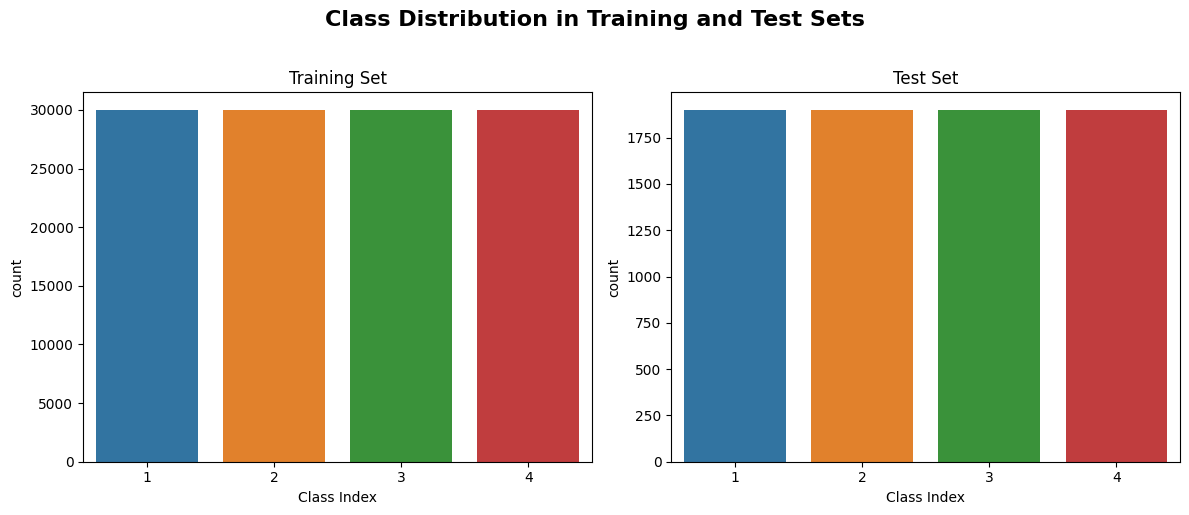

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# The count plot for df_train
sns.countplot(data=df_train, x='Class Index', ax=axes[0])
axes[0].set_title('Training Set')

# The count plot for df_test
sns.countplot(data=df_test, x='Class Index', ax=axes[1])
axes[1].set_title('Test Set')
plt.suptitle('Class Distribution in Training and Test Sets', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

We can observe that the classes are balanced across both sets.

## Preprocessing

### Class Label Encoding with OneHotEncoder

In the context of text classification task, we are dealing with categorical class labels representing the different news categories: World, Sports, Business, and Science/Technology. To facilitate the training of LSTM-based text classification model, it's crucial to encode these categorical labels into a numerical format that model can understand.

####OneHotEncoder
OneHotEncoder is technique for converting categorical variables into a binary matrix format and it is particularly useful when dealing with nominal data where there is no inherent order among the categories. Each unique class label(in this case, each news article's category) is assigned a unique index. OneHotEncoder creates a binary vector of length equal to the number of unique classes. This vector has a '1' at the index corresponding to the class label and '0' elsewhere.

####Example

* World - 1: [1, 0, 0, 0]
* Sports - 2: [0, 1, 0, 0]
* Business - 3: [0, 0, 1, 0]
* Science/Technology - 4: [0, 0, 0, 1]

This encoding ensures that the model understands the categorical nature of the classes and doesn't interpret them as ordinal values. Each class is treated as a distinct and independent category during training.

In [ ]:
one_hot = OneHotEncoder()
y_train = one_hot.fit_transform(df_train['Class Index'].values.reshape(-1,1)).toarray()
y_test = one_hot.fit_transform(df_test['Class Index'].values.reshape(-1,1)).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

###Title and description combination
 Combining titles and descriptions showed better accuracy than using them as separate features.



In [ ]:
X_train = df_train['Title'] + " " + df_train['Description']
x_test = df_test['Title'] + " " + df_test['Description']

Max Length of sentences in Dataset

In [ ]:
maxlen_test = x_test.map(lambda x: len(x.split())).max()
maxlen_tain = X_train.map(lambda x: len(x.split())).max()
maxlen = int(max(maxlen_test, maxlen_tain))
maxlen

177

In [ ]:
X_train = np.array(X_train, dtype=str)
x_test = np.array(x_test, dtype=str)

###Text Encoding with TextVectorization



In the context of a text classification, where the input data is textual information, efficient processing and encoding into numerical representations become essential,  since computers cannot understand raw text but are very good at understanding numbers.To achieve this, the TextVectorization layer provided by TensorFlow's Keras API was employed.
The TextVectorization layer acts as a pivotal bridge between the raw textual data and the numerical requirements of deep learning architecture, by transforming the input data into a format that can be effectively processed by subsequent layers of the model.

The processing of each example contains the following steps:

* Standardize each example (usually lowercasing + punctuation stripping)
* Split each example into substrings (usually words)
* Recombine substrings into tokens (usually ngrams)
* Index tokens (associate a unique int value with each token)
* Transform each example using this index, either into a vector of ints or a dense float vector.


In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000, output_mode='int',
                                            standardize = "lower_and_strip_punctuation")
encoder.adapt(X_train)

The encoder was created with the folowing parametrs

* max_tokens=2000: This parameter limits the vocabulary size to 2000 unique tokens. If there are more than 2000 unique tokens in input text data, the most frequent 2000 tokens will be kept, and the rest will be considered out-of-vocabulary (OOV) tokens.
* output_mode='int': This parameter specifies that the output of the TextVectorization layer should be integer-encoded sequences. Each split string token in input text is assigned a unique integer index, creating a fixed-size numerical representation for each sequence.
* standardize = "lower_and_strip_punctuation": This parameter is for standardization to apply to the input text. Text will be lowercased and all punctuation removed

Encoder.adapt(training_text_data) allows the TextVectorization layer to learn the vocabulary from the training text data, ensuring consistency in tokenization across the entire dataset. The resulting encoded_sequences represent the integer-encoded form of the input text, ready for consumption by our LSTM-based text classification model.

##RNNs and LSTMs

### What are vanilla RNNs and why we dont use them

#### Overview


Recurrent Neural Networks (RNNs) are a type of neural network architecture designed to work with sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form cycles, allowing them to maintain a memory of previous inputs in the sequence.

####Structure

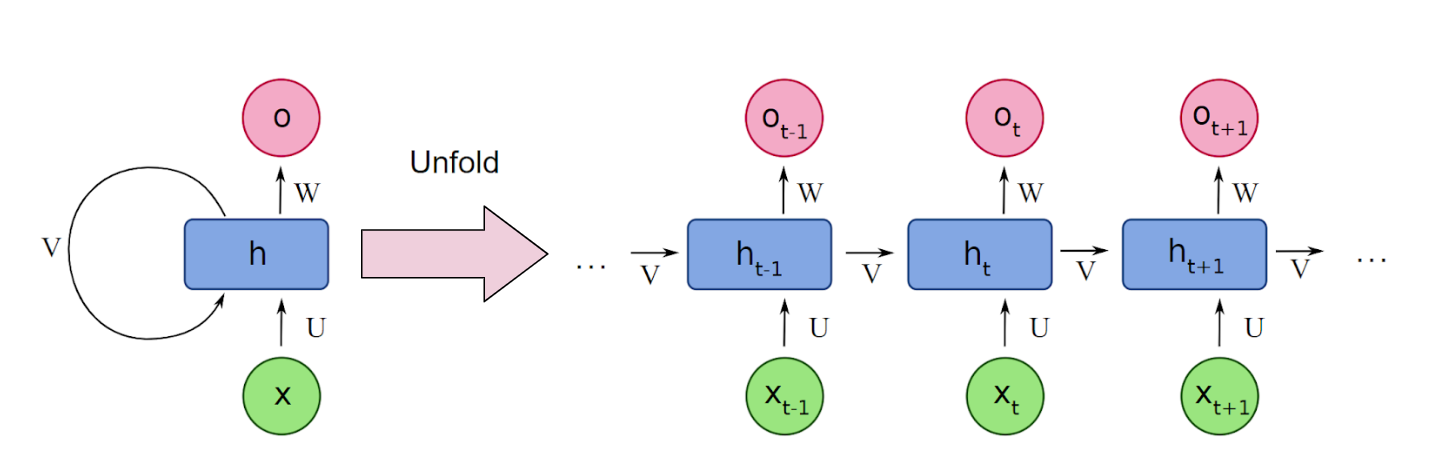


An RNN consists of recurrent units that take input at each time step and maintain a hidden state. The hidden state acts as a form of memory, capturing information from previous time steps.


* **Input at Time Step t:** Input at time step t is fed into the RNN.

* **Hidden State at Time Step t-1:** The hidden state from the previous time step t-1 is used as a form of memory.

* **Weight Matrices:**
  - U: Weights for the input at time step t.
  - V: Weights for the hidden state at time step t-1\.
  - W: Weights for the output.

* **Activation Function:** The activation function traditionally used in vanilla RNNs is the hyperbolic tangent (tanh) activation function. It squashes the output to be between -1 and 1, providing a smooth transition between states.

* **Output at Time Step t:** The output at time step t is computed based on the input, the previous hidden state, and the activation function.

**The hidden state** at time step \(t\) is computed as follows:

$$h_t = \tanh(U \cdot x_t + V \cdot h_{t-1} + b_h)$$

Where:
- $x_{t}$ is the input at time step t,
- $h_{t-1}$ is the hidden state from the previous time step,
- U and V are weight matrices,
- $b_h$ is the bias term for the hidden state.
<br>

<br>
**The output** ($o_t$) at time step t can be obtained by applying another set of weights W and an activation function (often softmax for classification tasks).

$$o_t = \text{softmax}(W \cdot h_t+ b_o) $$
Where:

- $ h_t $ is the hidden state at time step $ t $.
- $ W $ is the weight matrix for the output.
- $ b_o $ is the bias term for the output.
- $ \text{softmax} $ is the softmax activation function, commonly used for multi-class classification tasks. It transforms the raw scores into probability distributions over the different classes.

Mathematically, the softmax function is defined as follows for a vector $ x $ with elements $ x_i $:

$$ \text{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}} $$

This ensures that the output values are normalized and represent probabilities.

####Limitations

**Vanishing/Exploding Gradient Problem:**

Definition:

The vanishing/exploding gradient problem occurs when the gradients of the loss function with respect to the parameters become extremely small/big during backpropagation. This is especially problematic in deep networks or networks with long sequences.

Implications:

* **Vanishing gradient:** Layers that are far from the output receive weak gradients, and as a result, they learn very slowly or may not learn at all.
* **Exploding gradient:** The exploding gradient problem can lead to instability during training, causing the model to oscillate or diverge.

###What are LSTMs and why do we use them.

####Overview

Long Short-Term Memory networks (LSTMs) were introduced to overcome the limitations of traditional RNNs in handling long-range dependencies in sequential data. LSTMs have a more sophisticated architecture with memory cells and gates, allowing them to selectively remember or forget information.

###Structure

The gate structure in a Long Short-Term Memory (LSTM) network is a fundamental aspect that allows the model to selectively control the flow of information through the cell state. LSTMs have three gates: the Forget Gate $(f_t)$, the Input Gate ($i_t$), and the Output Gate ($o_t$). These gates play a crucial role in determining what information to retain, update, or output at each time step.



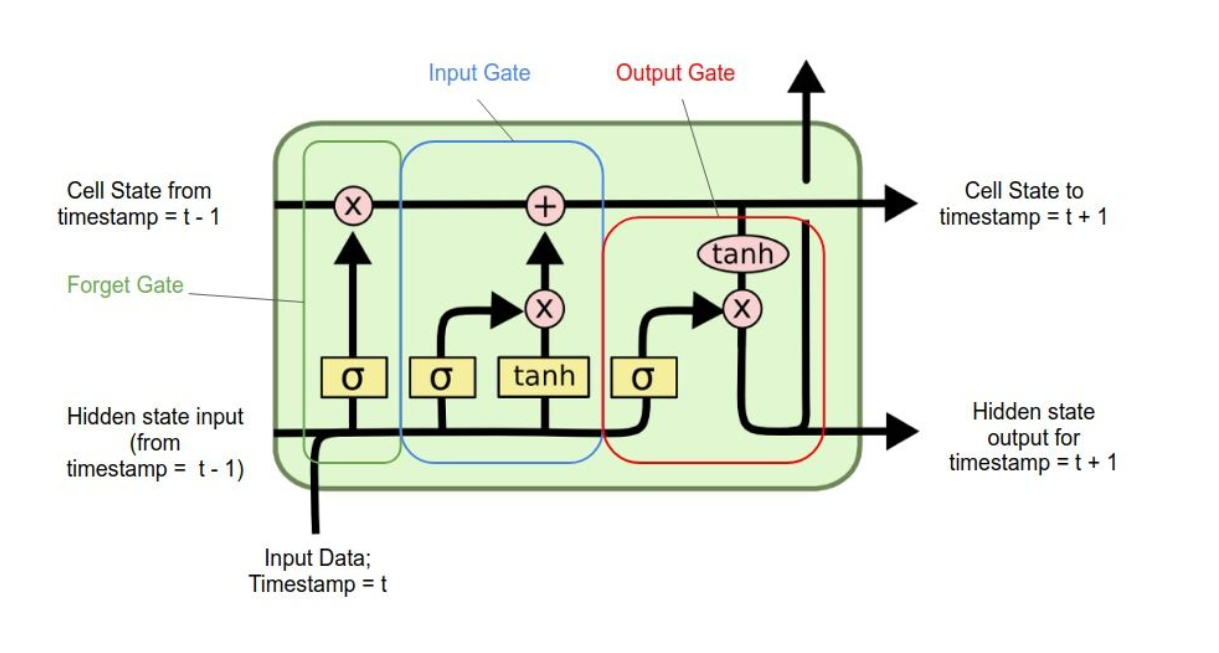

#### **Forget Gate ($f_t$)**
  - Function: <br>
  &nbsp; &nbsp; Decides what information from the previous cell state ($C_{t-1}$) should be forgotten.
  - Formula:

      $$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$
Where:
    - $f_t$ - Forget gate at time step $t$.
    - $\sigma$ - Sigmoid activation function.
    - $W_f$ - Weight matrix for the forget gate.
    - $[h_{t-1}, x_t]$ - Concatenation of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - $b_f$ - Bias term for the forget gate.

####**Input Gate ($i_t$):**
  - Function: <br>
  &nbsp; &nbsp; Determines what new information from the current input ($x_t$) should be added to the cell state.
  - Formula:
   $$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$
     
 Where:
    - $i_t$ - Input gate at time step $t$.
    - $\sigma$ - Sigmoid activation function.
    - $W_i$ - Weight matrix for the input gate.
    - $[h_{t-1}, x_t]$ - Concatenation of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - $b_i$ - Bias term for the input gate.
<br><br>
  $$ \tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)$$
  
  Where:
    - $\tilde{C}_t$ - Candidate cell state at time step $t$.
    - $\tanh$ - Hyperbolic tangent activation function.
    - $W_c$ - Weight matrix for the candidate cell state.
    - $[h_{t-1}, x_t]$ - Concatenation of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - $b_c$ - Bias term for the candidate cell state.

#### **Cell State $C_t$:**
   - The cell state is updated using the forget gate $f_t$, input gate $i_t$, and the candidate cell state $\tilde{C}_t$:
   
     $$ C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t \$$

#### **Output Gate ($o_t$):**
   - Function:<br>
   &nbsp; &nbsp; Regulates what information from the cell state $(C_t)$ should be used to compute the hidden state ($h_t$).
   - Formula:
   $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
 Where:
    - $o_t$ - Output gate at time step $t$.
    - $\sigma$ - Sigmoid activation function.
    - $W_o$ - Weight matrix for the output gate.
    - $[h_{t-1}, x_t]$ - Concatenation of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - $b_o$ - Bias term for the output gate.
<br>
<br>
   $$h_t = o_t \cdot \tanh(C_t)$$
   
 Where:
  - $h_t$ - current hidden state
  - $o_t$ - Output gate at time step $t$.
  - $\tanh$ - Hyperbolic tangent activation function.
  - $C_t$ - Cell state at time step $t$.

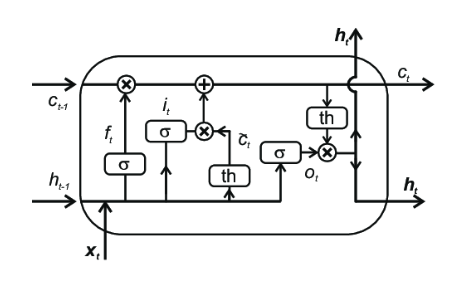

These gates work together to update the cell state and hidden state at each time step in an LSTM network. The sigmoid activation functions in the gates produce values between 0 and 1, regulating the information flow, while the tanh activation functions provide a smooth transition of values between -1 and 1, allowing for effective learning and information retention.

### Advantages


LSTMs can capture long-term dependencies more effectively.
They are well-suited for tasks involving sequential data, such as natural language processing.
In the context of text classification, LSTMs excel at understanding the contextual relationships between words in sentences, enabling the model to make informed predictions based on the entire input sequence.

In summary, while traditional RNNs face challenges in handling long-range dependencies, LSTMs offer an improved architecture that addresses these issues, making them particularly valuable for tasks involving sequential data like text classification.

##Model Architecture

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
])

The model is designed for a text classification task using a Sequential model in TensorFlow/Keras. It includes several layers for processing and classifying textual data.

1. Text Vectorization (Encoder) Layer: Converts input text data into a numerical format as descibed above.

2. Embedding Layer: Layer takes the integer-encoded tokens produced by the Encoder and transforms them into dense vectors of dimensionality 32. These vectors capture semantic relationships between words and create a continuous representation of the input text.
3. LSTM (Long Short-Term Memory) Layer: The LSTM layer, with 32 units, processes the sequence of word embeddings generated by the Embedding layer. The mask_zero=True parameter indicates that the model should mask the zero-padding in the input sequences.
4. Dense Layers with ReLU Activation: Layer introduces non-linearity and learns complex patterns. The model uses three Dense layers with 32, 16, and 8 units, respectively. Each Dense layer is followed by a Rectified Linear Unit (ReLU) activation function.
5. Dropout Layers: Dropout helps prevent overfitting by randomly "dropping out" a fraction of the input units during training, forcing the model to be more robust and generalize better to unseen data. Between each Dense layer, there is a Dropout layer with a dropout rate of 0.25.
6. Output Dense Layer with Softmax Activation: Produces probability distribution over output classes. The final Dense layer has 4 units and uses the softmax activation function. This layer outputs probabilities for each class, and the class with the highest probability is predicted as the final classification.



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 32)          64000     
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

In summary, the model processes input text data through a Text Vectorization layer, converts it to dense embeddings, captures sequential patterns with an LSTM layer, and uses dense layers with ReLU activations and dropout for feature learning. The final output layer provides class probabilities for the text classification task.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

The model.compile function configures the model for training by specifying the Adam optimizer with a 0.001 learning rate, choosing Categorical Crossentropy as the loss function for multiclass classification, and using accuracy as the metric for evaluating the model's performance. This setup ensures that the model is equipped with the necessary components to efficiently learn from the training data and make accurate predictions on unseen data.

##Training and Evaluation:

In [ ]:
checkpoint_path = "best_model"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    save_format='tf',
    verbose=1
)

**checkpoint_path** holds the file path("best_model.h5") where the best model weights will be saved.

**ModelCheckpoint** is a callback provided by Keras that allows saving the model or its weights during training based on specified conditions.

**monitor='val_accuracy'** is configured to monitor the validation accuracy during training. It will save the model weights only when the validation accuracy improves.

**mode='max'** indicates that higher values of the monitored metric (validation accuracy) are considered better.

**save_best_only=True** is configured to save only the best model

**save_weights_only=True** is configured to save only the model weights not the entire model

**verbose=1** The verbosity level is set to 1, meaning that progress updates will be printed to the console during training when the callback saves the weights.

By using this callback during model training, we ensure that the best model weights (based on validation accuracy) are saved.

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
3750/3750 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.7535
Epoch 1: val_accuracy improved from -inf to 0.87789, saving model to best_model
3750/3750 [==============================] - 73s 17ms/step - loss: 0.7033 - accuracy: 0.7535 - val_loss: 0.3928 - val_accuracy: 0.8779
Epoch 2/10
3745/3750 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.8407
Epoch 2: val_accuracy improved from 0.87789 to 0.88053, saving model to best_model
3750/3750 [==============================] - 41s 11ms/step - loss: 0.5065 - accuracy: 0.8407 - val_loss: 0.3718 - val_accuracy: 0.8805
Epoch 3/10
3746/3750 [============================>.] - ETA: 0s - loss: 0.4736 - accuracy: 0.8440
Epoch 3: val_accuracy improved from 0.88053 to 0.88066, saving model to best_model
3750/3750 [==============================] - 41s 11ms/step - loss: 0.4737 - accuracy: 0.8440 - val_loss: 0.3740 - val_accuracy: 0.8807
Epoch 4/10
3746/3750 [============================>.] -

The training code uses the model.fit method to train the model on the training dataset. The training process is repeated for 10 epochs. During each epoch, the model updates its weights based on the training data, iteratively improving its ability to make accurate predictions.The validation data (x_test and y_test) are provided to monitor the model's performance on data it has not seen during training. This helps assess whether the model generalizes well to new, unseen samples.

##Results and Analysis

238/238 - 1s - loss: 0.3961 - accuracy: 0.8895 - 1s/epoch - 5ms/step


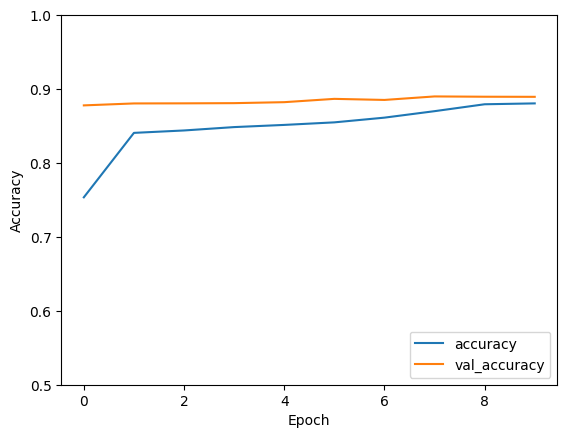

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

test_loss,test_acc = model.evaluate(x_test,y_test,verbose= 2)

238/238 - 1s - loss: 0.3961 - accuracy: 0.8895 - 1s/epoch - 4ms/step


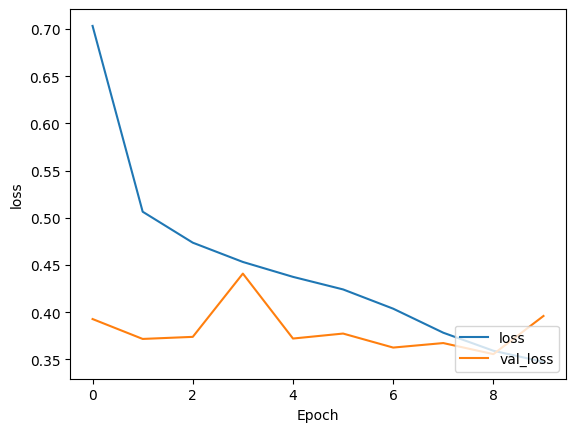

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

test_loss,test_acc = model.evaluate(x_test,y_test,verbose= 2)

Loading the best model weights

In [ ]:
model.load_weights("best_model")

238/238 [==============================] - 2s 4ms/step


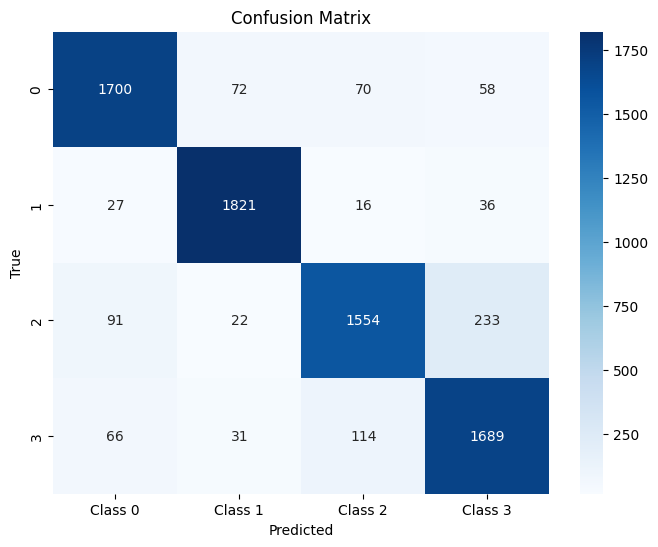

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

##Test it yourself

In [ ]:
def predict_class(title, description, model):
    text = np.array([title + " " + description], dtype=str)  # Pass title and description as a NumPy array
    prediction = model.predict(text)

    # Convert the prediction to a class label
    predicted_class_index = np.argmax(prediction)

    # Map the class index to the corresponding class label
    class_labels = ["World", "Sports", "Business", "Science/Technology"]
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label


World News

In [ ]:
new_article_title = "Two Wars, 50 Elections: The Economy Faces Rising Geopolitical Risks"
new_article_description = "Next year could see increasing volatility as persistent military conflicts and economic uncertainty influence voting in national elections across the globe."

predicted_class = predict_class(new_article_title, new_article_description, model)
print("Predicted Class Label:", predicted_class)


1/1 [==============================] - 0s 19ms/step
Predicted Class Label: World


Sports News

In [ ]:
new_article_title = "Jane Couch: Pioneer of women's boxing to be inducted into Hall of Fame"
new_article_description = "Jane Couch was just 27 years old when she took on the British boxing world for the right to fight in the professional ranks."
predicted_class = predict_class(new_article_title, new_article_description, model)
print("Predicted Class Label:", predicted_class)

1/1 [==============================] - 0s 20ms/step
Predicted Class Label: Sports


Business News

In [ ]:
new_article_title = "Washington Post Reaches a Contract Deal With Its Newsroom Union"
new_article_description = "The tentative agreement would end 18 months of negotiations that included a one-day work stoppage."
predicted_class = predict_class(new_article_title, new_article_description, model)
print("Predicted Class Label:", predicted_class)

1/1 [==============================] - 0s 21ms/step
Predicted Class Label: Business


Science/Technology News

In [ ]:
new_article_title = "U.S. Regulators Propose New Online Privacy Safeguards for Children"
new_article_description = "The F.T.C. called for sweeping changes that could curb how social media, game and learning apps use and monetize youngsters’ data."

predicted_class = predict_class(new_article_title, new_article_description, model)
print("Predicted Class Label:", predicted_class)

1/1 [==============================] - 0s 18ms/step
Predicted Class Label: Science/Technology
